## Thực hiện hợp đồng giao dịch có ký quỹ trên mạng preprod

### Bước 1: Tạo ví cho các bên liên quan

**Tạo thư mục tên là escrow-contract để lưu các files liên quan**

In [ ]:
mkdir -p ~/notebooks/escrow-contract

In [ ]:
cd ~/notebooks/escrow-contract/

In [ ]:
pwd

**Tạo signing key và verification key cho các bên tham gia vào hợp đồng**

In [ ]:
cardano-cli address key-gen \
--verification-key-file nguoi-mua.vkey \
--signing-key-file nguoi-mua.skey

cardano-cli address key-gen \
--verification-key-file nguoi-ban.vkey \
--signing-key-file nguoi-ban.skey

cardano-cli address key-gen \
--verification-key-file trung-gian.vkey \
--signing-key-file trung-gian.skey

ls

**Tạo địa chỉ ví từ verification key**

In [ ]:
cardano-cli address build \
--payment-verification-key-file nguoi-mua.vkey \
--testnet-magic 1 \
--out-file nguoi-mua.addr

cardano-cli address build \
--payment-verification-key-file nguoi-ban.vkey \
--testnet-magic 1 \
--out-file nguoi-ban.addr

cardano-cli address build \
--payment-verification-key-file trung-gian.vkey \
--testnet-magic 1 \
--out-file trung-gian.addr

ls

**Lưu lại đường dẫn đến các files signing key và địa chỉ ví của các bên tham gia vào các biến để sau này tiện sử dụng**

In [ ]:
MEDIATOR_SKEY=trung-gian.skey
MEDIATOR_ADDRESS=$(< trung-gian.addr)

BUYER_SKEY=nguoi-mua.skey
BUYER_ADDRESS=$(< nguoi-mua.addr)

SELLER_SKEY=nguoi-ban.skey
SELLER_ADDRESS=$(< nguoi-ban.addr)

In [ ]:
echo "Địa chỉ ví của người trung gian: $MEDIATOR_ADDRESS"
echo "Địa chỉ ví của người mua: $BUYER_ADDRESS"
echo "Địa chỉ ví của người bán: $SELLER_ADDRESS"

**Chuyển tADA vào ví của các bên, sau đó liệt kê các UTxO của từng địa chỉ ví xem đã nhận được tADA chưa**

_Chuyển 50 tADA vào ví của người trung gian, 240 tADA vào ví của người mua, và 30 tADA vào ví của người bán_

In [ ]:
printf "\nCác UTXOs của người trung gian:\n"
cardano-cli query utxo --testnet-magic 1 --address $MEDIATOR_ADDRESS
printf "\nCác UTXOs của người mua:\n"
cardano-cli query utxo --testnet-magic 1 --address $BUYER_ADDRESS
printf "\nCác UTXOs của người bán:\n"
cardano-cli query utxo --testnet-magic 1 --address $SELLER_ADDRESS

### Bước 2: Thiết lập các tham số dùng trong hợp đồng

In [ ]:
INITIAL_LOVELACE=3000000              # Khi triển khai hợp đồng Marlowe lên blockchain thì sẽ gửi tạm 3₳ vào hợp đồng
PRICE=200000000                       # Giá của sản phẩm là 200₳
MINIMUM_ADA=2000000                   # Số lovelace tối thiểu cần có cho mỗi UTxO có chứa native token là 2₳

SELLER_ROLE=NguoiBan                  # Đặt tên token của role seller là NguoiBan
BUYER_ROLE=NguoiMua                   # Đặt tên token của role buyer là NguoiMua
MEDIATOR_ROLE=TrungGian               # Đặt tên token của role mediator là TrungGian

NOW=$(($(date -u +%s)*1000))          # Thời gian hiện tại tính theo POSIX milliseconds.
HOUR=$((60*60*1000))                  # Số miliseconds trong 1 giờ.
PAYMENT_DEADLINE=$((NOW+24*HOUR))     # Thời hạn người mua cần deposit tiền vào hợp đồng, (24 giờ kể từ lúc này).
COMPLAINT_DEADLINE=$((NOW+48*HOUR))   # Thời hạn người mua khiếu nại (48 giờ kể từ lúc này).
DISPUTE_DEADLINE=$((NOW+72*HOUR))     # Thời hạn người bán phản biện (72 giờ kể từ lúc này).
MEDIATION_DEADLINE=$((NOW+96*HOUR))   # Thời hạn người trung gian đưa ra quyết định (96 giờ kể từ lúc này).

In [ ]:
echo "Thời gian hiện tại: $NOW (POSIX) => $(date -d @$(($NOW / 1000)) "+%H:%M:%S %d/%m/%Y UTC")"
echo "Thời hạn người mua cần deposit: $PAYMENT_DEADLINE (POSIX) => $(date -d @$(($PAYMENT_DEADLINE / 1000)) "+%H:%M:%S %d/%m/%Y UTC")"
echo "Thời hạn người mua khiếu nại: $COMPLAINT_DEADLINE (POSIX) => $(date -d @$(($COMPLAINT_DEADLINE / 1000)) "+%H:%M:%S %d/%m/%Y UTC")"
echo "Thời hạn người bán phản biện: $DISPUTE_DEADLINE (POSIX) => $(date -d @$(($DISPUTE_DEADLINE / 1000)) "+%H:%M:%S %d/%m/%Y UTC")"
echo "Thời hạn người trung gian đưa ra quyết định: $MEDIATION_DEADLINE (POSIX) => $(date -d @$(($MEDIATION_DEADLINE / 1000)) "+%H:%M:%S %d/%m/%Y UTC")"

### Bước 3: Tạo ra các role token và gửi vào địa chỉ ví của các bên tương ứng

In [ ]:
marlowe-cli --conway-era util mint --issuer $MEDIATOR_ADDRESS:$MEDIATOR_SKEY             \
						--out-file /dev/null                                             \
						--submit 600                                                     \
						"$SELLER_ROLE":$SELLER_ADDRESS                                   \
						"$BUYER_ROLE":$BUYER_ADDRESS                                     \
						"$MEDIATOR_ROLE":$MEDIATOR_ADDRESS

**Kiểm tra xem token đã được mint và gửi đến đúng địa chỉ ví của các bên tương ứng chưa**

In [ ]:
for n in "$MEDIATOR_ROLE" "$BUYER_ROLE" "$SELLER_ROLE"
do
  echo "$(echo -n $n | basenc --base16 | tr '[:upper:]' '[:lower:]') = $n"
done

In [ ]:
printf "\nCác UTXOs của người trung gian:\n"
cardano-cli query utxo --testnet-magic 1 --address $MEDIATOR_ADDRESS

printf "\nCác UTXOs của người mua:\n"
cardano-cli query utxo --testnet-magic 1 --address $BUYER_ADDRESS

printf "\nCác UTXOs của người bán:\n"
cardano-cli query utxo --testnet-magic 1 --address $SELLER_ADDRESS

**Lưu lại UTxO của các bên để sử dụng cho bước tiếp theo**

In [ ]:
TX_0_MEDIATOR_ADA_ONLY="55df0b14eba5bbcdd6cc6fe6b41542b5a191d228ffcb435d2dec8c26ea74e5b0#0"
TX_0_MEDIATOR_TOKEN="55df0b14eba5bbcdd6cc6fe6b41542b5a191d228ffcb435d2dec8c26ea74e5b0#3"

TX_0_BUYER_ADA_ONLY="409fb75b0f6fa4a0600989022d8931638291ebcefbe7531acc98c08d97588bc4#1"
TX_0_BUYER_TOKEN="55df0b14eba5bbcdd6cc6fe6b41542b5a191d228ffcb435d2dec8c26ea74e5b0#2"

# cce229c67c949398da3d5b135037c8858fbace54542f890f57d4639c2d99cf6
# ccce229c67c949398da3d5b135037c8858fbace54542f890f57d4639c2d99cf6
TX_0_SELLER_ADA_ONLY="409fb75b0f6fa4a0600989022d8931638291ebcefbe7531acc98c08d97588bc4#2"
TX_0_SELLER_TOKEN="55df0b14eba5bbcdd6cc6fe6b41542b5a191d228ffcb435d2dec8c26ea74e5b0#1"

**Lưu lại policy id và tên của các token**

In [ ]:
ROLES_CURRENCY=e3d82d95fd81f7cdbfc75ef19e2cfbb212e0e82abd194002831b5809

MEDIATOR_TOKEN="$ROLES_CURRENCY.$MEDIATOR_ROLE"
BUYER_TOKEN="$ROLES_CURRENCY.$BUYER_ROLE"
SELLER_TOKEN="$ROLES_CURRENCY.$SELLER_ROLE"

echo "MEDIATOR_TOKEN: $MEDIATOR_TOKEN"
echo "BUYER_TOKEN: $BUYER_TOKEN"
echo "SELLER_TOKEN: $SELLER_TOKEN"

### Bước 4: Triển khai và tương tác với hợp đồng trên blockchain

**Tạo 2 file JSON chứa nội dung và trạng thái của hợp đồng**

In [ ]:
marlowe-cli --conway-era template escrow --minimum-ada "$INITIAL_LOVELACE"          \
                            --price "$PRICE"                                        \
                            --seller "$SELLER_ROLE"                                 \
                            --buyer "$BUYER_ROLE"                                   \
                            --mediator "$MEDIATOR_ROLE"                             \
                            --payment-deadline "$PAYMENT_DEADLINE"                  \
                            --complaint-deadline "$COMPLAINT_DEADLINE"              \
                            --dispute-deadline "$DISPUTE_DEADLINE"                  \
                            --mediation-deadline "$MEDIATION_DEADLINE"              \
                            --out-contract-file tx-1.contract                       \
                            --out-state-file    tx-1.state

#### Transaction 1: Người trung gian triển khai hợp đồng lên mạng blockchain

**Các UTxOs trong transaction 1**

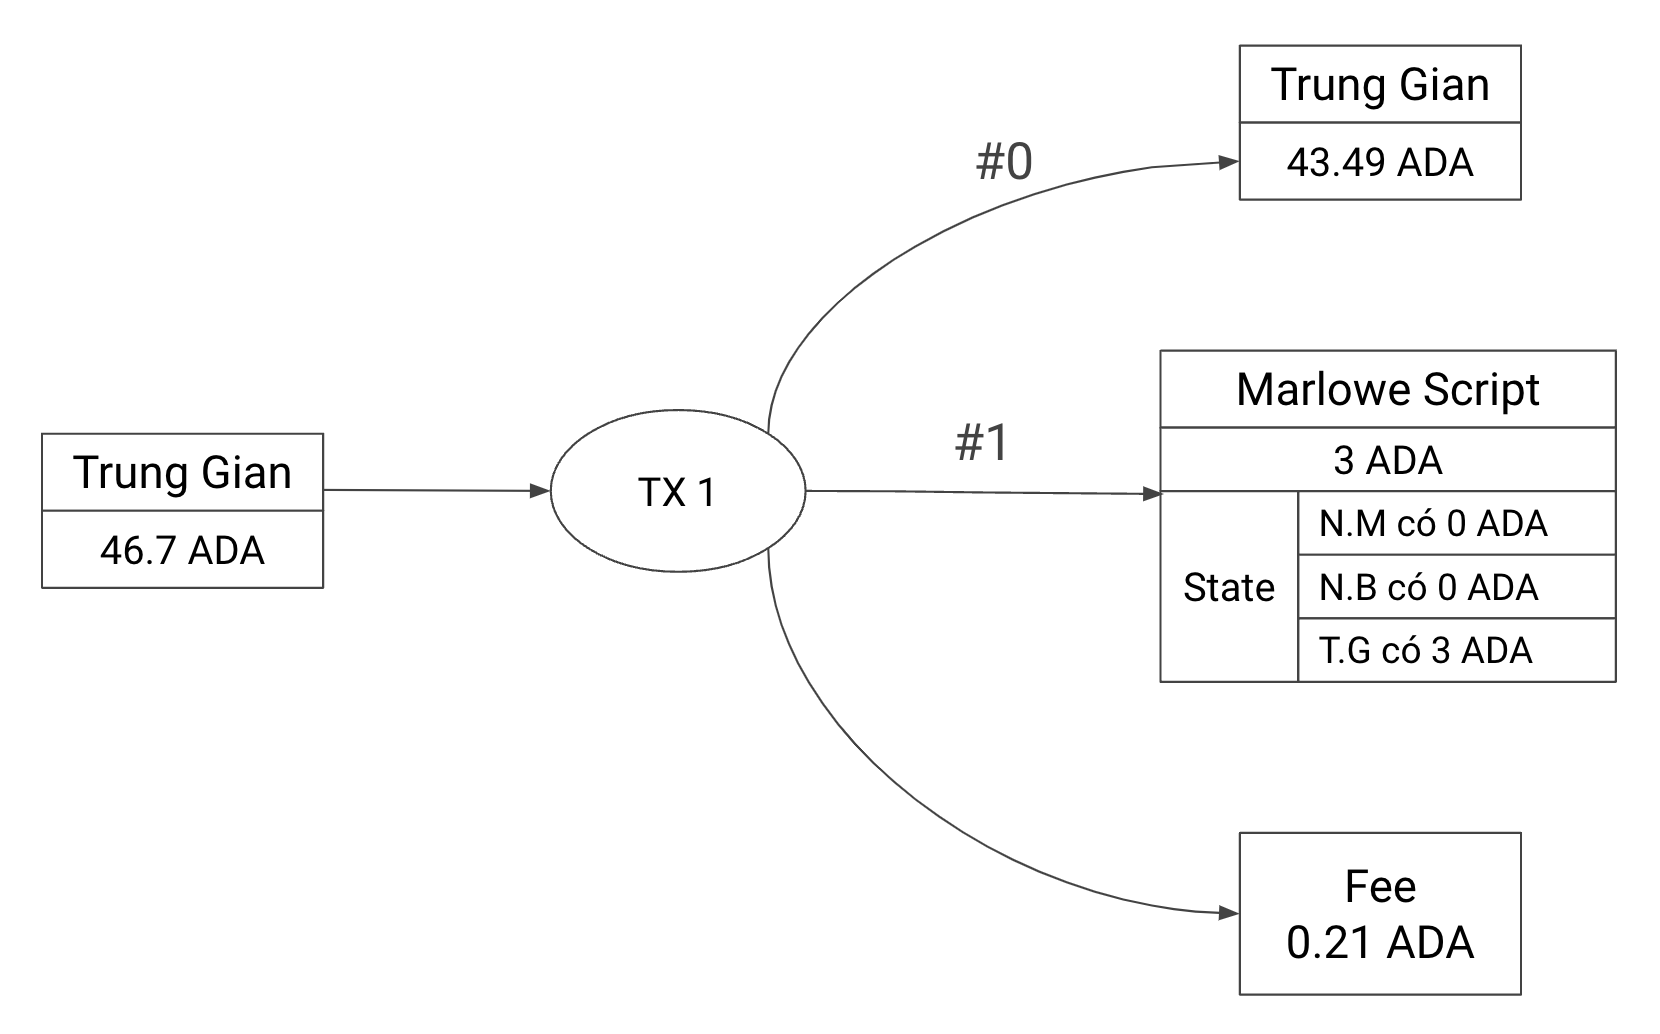

**Tạo file .marlowe chứa nội dung hợp đồng, trạng thái của nó, Plutus Validator và thông tin về network**

In [ ]:
marlowe-cli --conway-era run initialize --roles-currency "$ROLES_CURRENCY"        \
                           --permanently-without-staking                          \
                           --contract-file tx-1.contract                          \
                           --state-file    tx-1.state                             \
                           --out-file      tx-1.marlowe                           \
                           --print-stats

# permanently-without-staking => Reference Scripts (CIP-33)

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Validator size: 11079
Base-validator cost: ExBudget {exBudgetCPU = ExCPU 10896100, exBudgetMemory = ExMemory 68200}
```

**Dùng lệnh analyze để phân tích hợp đồng (file .marlowe) xem có thể chạy trên Cardano blockchain được không**

In [ ]:
marlowe-cli --conway-era run analyze --marlowe-file tx-1.marlowe

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_

```
- Preconditions:
    Duplicate accounts: []
    Duplicate bound values: []
    Duplicate choices: []
    Invalid account parties: []
    Invalid account tokens: []
    Invalid choice parties: []
    Invalid roles currency: false
    Non-positive account balances: []
- Role names:
    Blank role names: false
    Invalid role names: []
- Tokens:
    Invalid tokens: []
- Maximum value:
    Actual: 96
    Invalid: false
    Maximum: 5000
    Percentage: 1.92
    Unit: byte
- Minimum UTxO:
    Requirement: 1116290
- Execution cost:
    Memory:
      Actual: 4634706
      Invalid: false
      Maximum: 14000000
      Percentage: 33.105042857142855
    Steps:
      Actual: 886149821
      Invalid: false
      Maximum: 10000000000
      Percentage: 8.86149821
- Transaction size:
    Actual: 12728
    Invalid: false
    Maximum: 16384
    Percentage: 77.685546875
```

**Người trung gian sử dụng ADA của mình để triển khai hợp đồng**

In [ ]:
marlowe-cli --conway-era run execute --tx-in "$TX_0_MEDIATOR_ADA_ONLY"   \
                        --change-address "$MEDIATOR_ADDRESS"             \
                        --required-signer "$MEDIATOR_SKEY"               \
                        --marlowe-out-file tx-1.marlowe                  \
                        --out-file tx-1.raw                              \
                        --print-stats                                    \
                        --submit=600

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_1=33fe140376cf8c13a73af62afede6f8065322437325665953f9ae1737764fa57

In [ ]:
cardano-cli query utxo --testnet-magic "$CARDANO_TESTNET_MAGIC" --tx-in "$TX_1#0" --tx-in "$TX_1#1"

#### Transaction 2: Người mua gửi tiền vào tài khoản nội bộ của người bán

**Các UTxOs trong transaction 2**

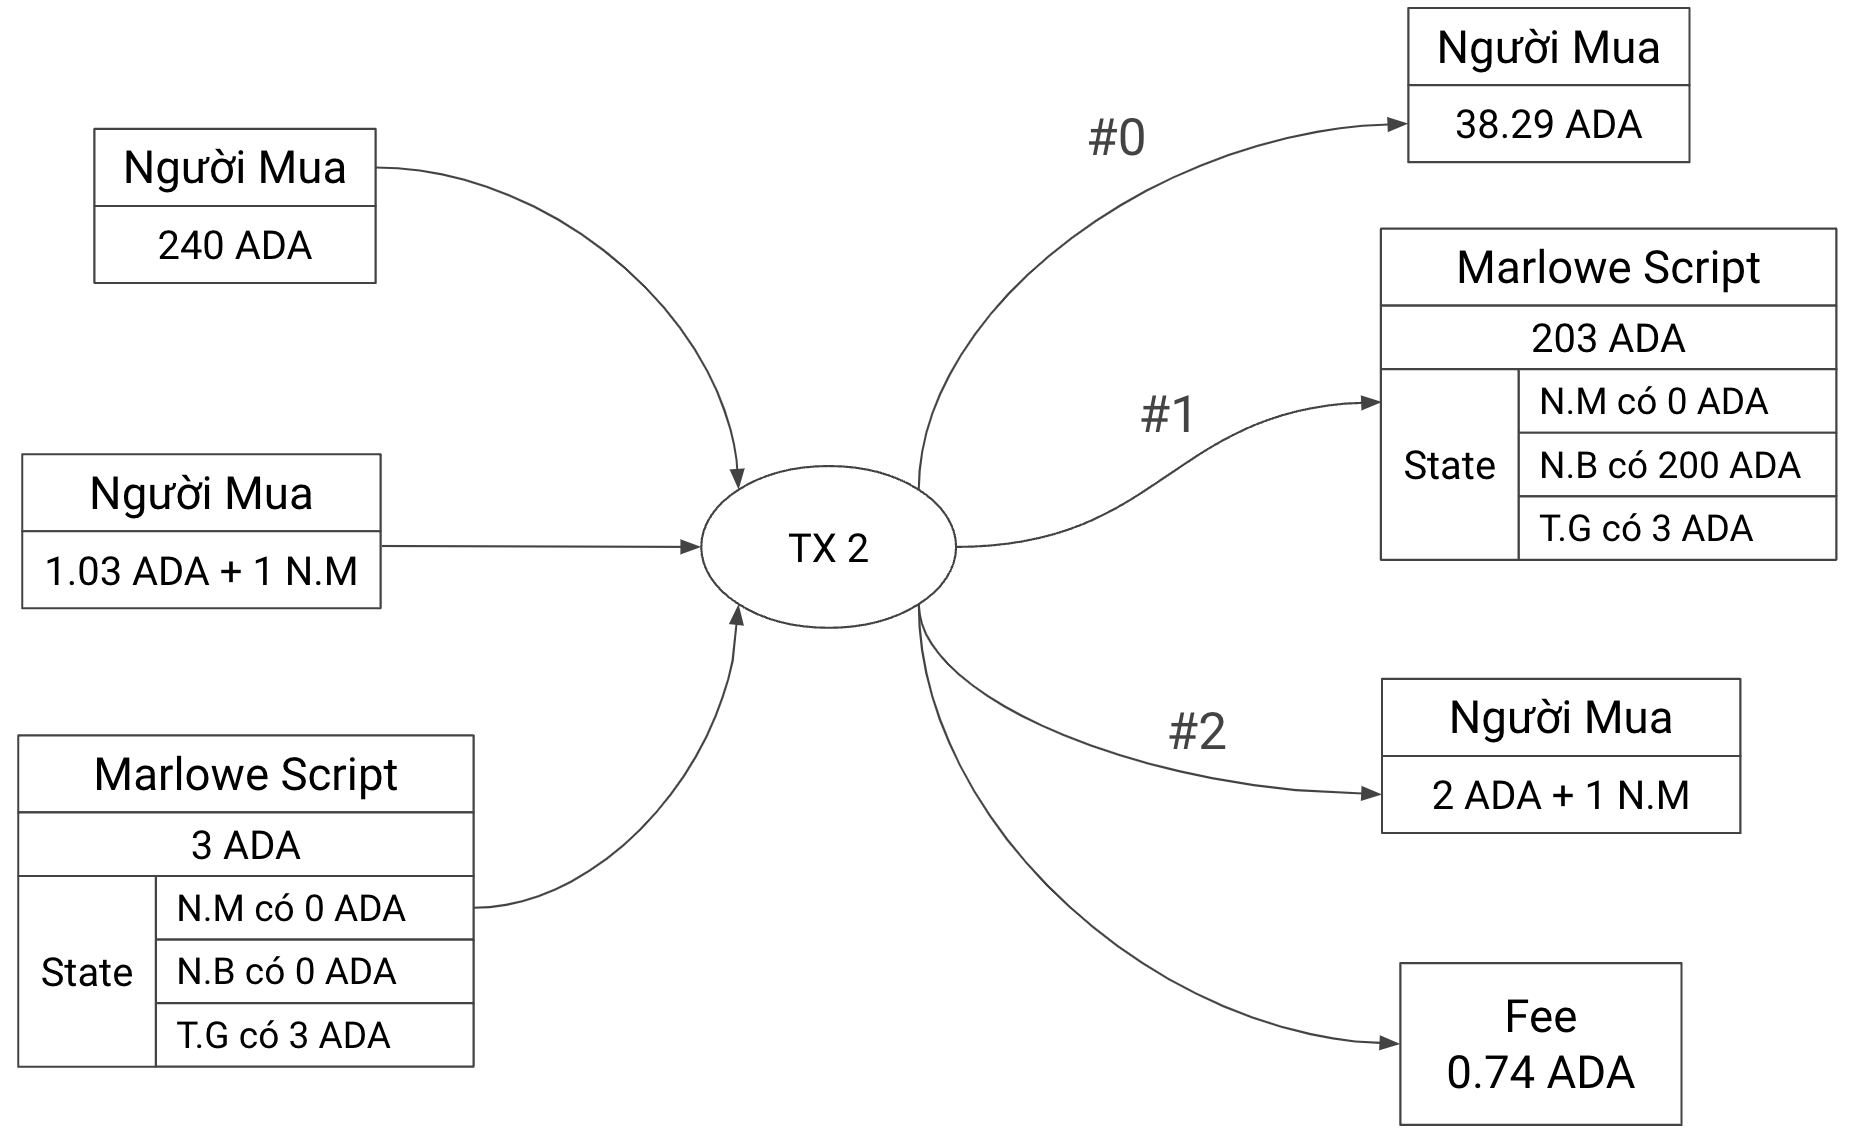

**Tạo ra file .marlowe chứa thông tin về trạng thái tiếp theo của hợp đồng**

In [ ]:
marlowe-cli --conway-era run prepare --marlowe-file tx-1.marlowe           \
                        --deposit-account "$SELLER_ROLE"                   \
                        --deposit-party "$BUYER_ROLE"                      \
                        --deposit-amount "$PRICE"                          \
                        --invalid-before "$NOW"                            \
                        --invalid-hereafter "$((NOW+9*HOUR))"              \
                        --out-file tx-2.marlowe                            \
                        --print-stats

**Thực hiện bước tiếp theo của hợp đồng**
_(Trạng thái hiện tại + Bước tiếp theo = Trạng thái tiếp theo)_

In [ ]:
marlowe-cli --conway-era run execute --marlowe-in-file tx-1.marlowe           \
                        --tx-in-marlowe "$TX_1#1"                             \
                        --tx-in-collateral "$TX_0_BUYER_ADA_ONLY"             \
                        --tx-in "$TX_0_BUYER_ADA_ONLY"                        \
                        --tx-in "$TX_0_BUYER_TOKEN"                           \
                        --required-signer "$BUYER_SKEY"                       \
                        --marlowe-out-file tx-2.marlowe                       \
                        --tx-out "$BUYER_ADDRESS+$MINIMUM_ADA+1 $BUYER_TOKEN" \
                        --change-address "$BUYER_ADDRESS"                     \
                        --out-file tx-2.raw                                   \
                        --print-stats                                         \
                        --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 1050633
Size: 12812 / 16384 = 78%
Execution units:
  Memory: 4308550 / 14000000 = 30%
  Steps: 811984768 / 10000000000 = 8%
TxId "d6ea1faf88a058d0e9b4c6ee380c388f06d8c6a3417105ed62a1b6b176f2d15e"
```

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_2=2431839d46ce6d4a455d644f3dfce69cabcacb920497f24c3ac5781eb8ab5a8e

In [ ]:
cardano-cli query utxo --testnet-magic "$CARDANO_TESTNET_MAGIC" --tx-in "$TX_2#0" --tx-in "$TX_2#1" --tx-in "$TX_2#2"

#### Transaction 3: Người mua khiếu nại rằng chưa nhận được hàng

**Các UTxOs trong transaction 3**

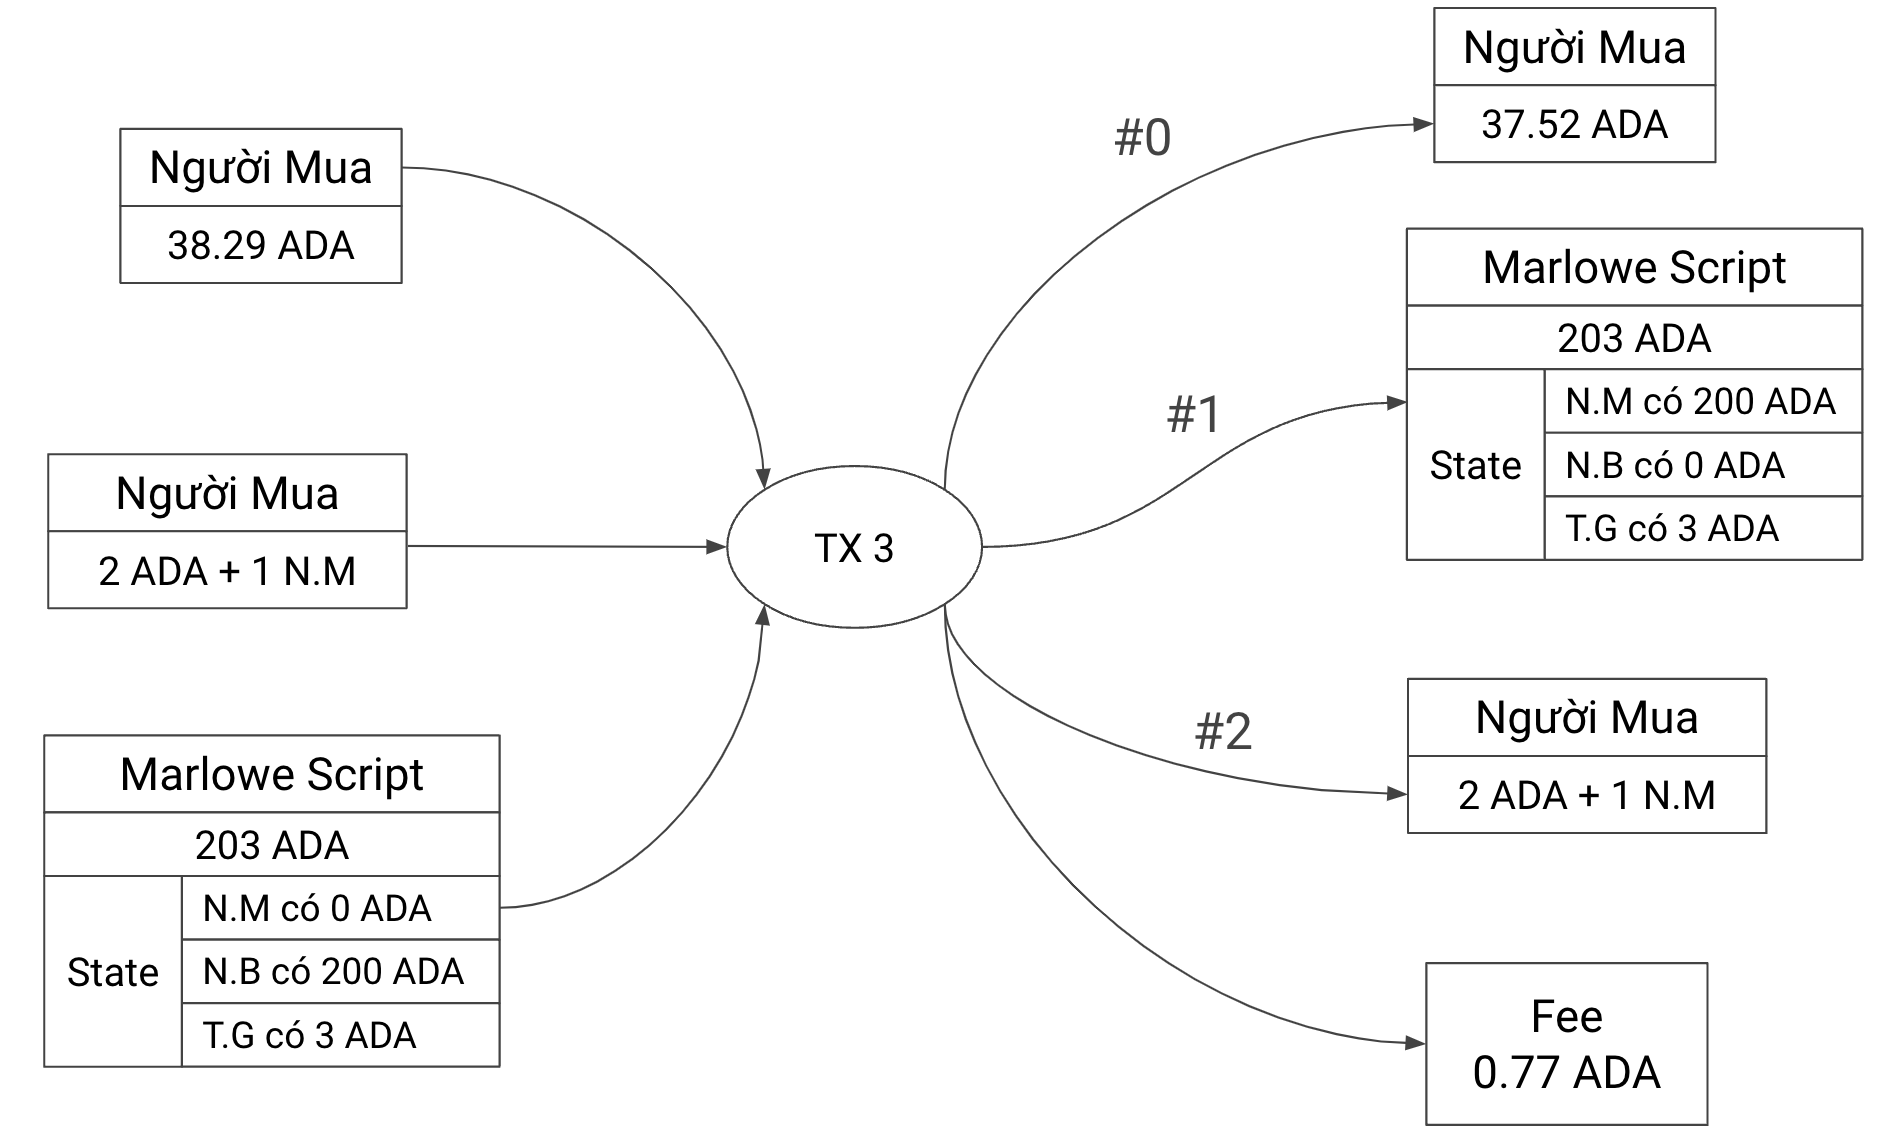

**Tạo ra file .marlowe chứa thông tin về trạng thái tiếp theo của hợp đồng**

In [ ]:
marlowe-cli --conway-era run prepare --marlowe-file tx-2.marlowe           \
                        --choice-name "Report problem"                     \
                        --choice-party "$BUYER_ROLE"                       \
                        --choice-number 1                                  \
                        --invalid-before "$NOW"                            \
                        --invalid-hereafter "$((NOW+9*HOUR))"              \
                        --out-file tx-3.marlowe                            \
                        --print-stats

**Thực hiện bước tiếp theo của hợp đồng**
_(Trạng thái hiện tại + Bước tiếp theo = Trạng thái tiếp theo)_

In [ ]:
marlowe-cli --conway-era run execute --marlowe-in-file tx-2.marlowe           \
                        --tx-in-marlowe "$TX_2#1"                             \
                        --tx-in-collateral "$TX_2#0"                          \
                        --tx-in "$TX_2#0"                                     \
                        --tx-in "$TX_2#2"                                     \
                        --required-signer "$BUYER_SKEY"                       \
                        --marlowe-out-file tx-3.marlowe                       \
                        --tx-out "$BUYER_ADDRESS+$MINIMUM_ADA+1 $BUYER_TOKEN" \
                        --change-address "$BUYER_ADDRESS"                     \
                        --out-file tx-3.raw                                   \
                        --print-stats                                         \
                        --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 1085999
Size: 12637 / 16384 = 77%
Execution units:
  Memory: 4901574 / 14000000 = 35%
  Steps: 934716445 / 10000000000 = 9%
TxId "241261817cf1f439094c43e500cbef6c73164e128cc43c137644781f4e9ee5e0"
```

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_3=46c9e07fc4c80ae876fa111bcc7e3c0962c849965343178d6ddb18baecb17962

In [ ]:
cardano-cli query utxo --testnet-magic "$CARDANO_TESTNET_MAGIC" --tx-in "$TX_3#0" --tx-in "$TX_3#1" --tx-in "$TX_3#2"

#### Transaction 4: Người bán phản biện rằng hàng đã được giao

**Các UTxOs trong transaction 4**

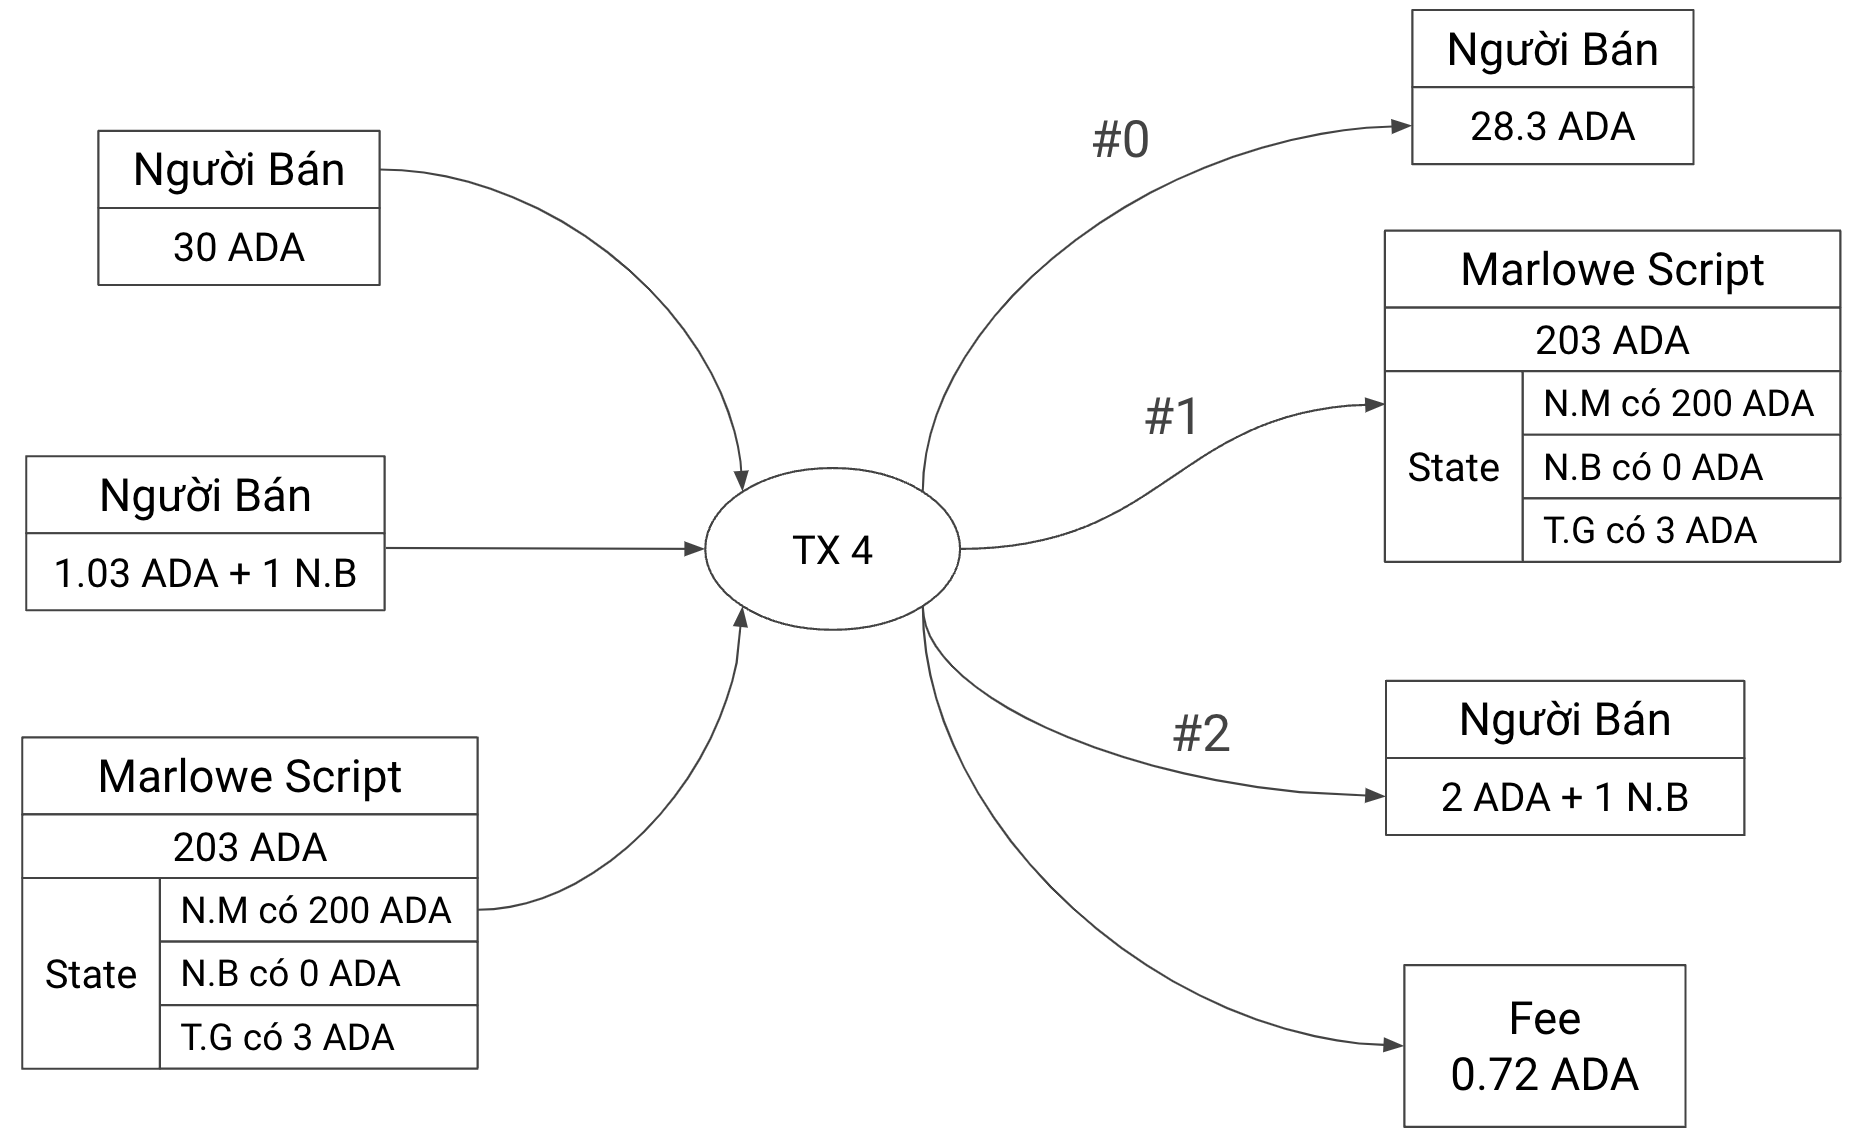

**Tạo ra file .marlowe chứa thông tin về trạng thái tiếp theo của hợp đồng**

In [ ]:
marlowe-cli --conway-era run prepare --marlowe-file tx-3.marlowe            \
                        --choice-name "Dispute problem"                     \
                        --choice-party "$SELLER_ROLE"                       \
                        --choice-number 0                                   \
                        --invalid-before "$NOW"                             \
                        --invalid-hereafter "$((NOW+9*HOUR))"               \
                        --out-file tx-4.marlowe                             \
                        --print-stats

**Thực hiện bước tiếp theo của hợp đồng**
_(Trạng thái hiện tại + Bước tiếp theo = Trạng thái tiếp theo)_

In [ ]:
marlowe-cli --conway-era run execute --marlowe-in-file tx-3.marlowe                          \
                        --tx-in-marlowe "$TX_3#1"                                            \
                        --tx-in-collateral "$TX_0_SELLER_ADA_ONLY"                           \
                        --tx-in "$TX_0_SELLER_ADA_ONLY"                                      \
                        --tx-in "$TX_0_SELLER_TOKEN"                                         \
                        --required-signer "$SELLER_SKEY"                                     \
                        --marlowe-out-file tx-4.marlowe                                      \
                        --tx-out "$SELLER_ADDRESS+$MINIMUM_ADA+1 $SELLER_TOKEN"              \
                        --change-address "$SELLER_ADDRESS"                                   \
                        --out-file tx-4.raw                                                  \
                        --print-stats                                                        \
                        --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 1037243
Size: 12413 / 16384 = 75%
Execution units:
  Memory: 4360356 / 14000000 = 31%
  Steps: 828313098 / 10000000000 = 8%
TxId "aca56a7340579ce2a0a24102fa49d25f686a21caf0c9322637a97736db0b8a76"
```

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_4=8a4f39b7ee52e8dfab946b649cceb2b398bfb0b6328310d14f10abd6d1dacdc9

In [ ]:
cardano-cli query utxo --testnet-magic "$CARDANO_TESTNET_MAGIC" --tx-in "$TX_4#0" --tx-in "$TX_4#1" --tx-in "$TX_4#2"

#### Giao dịch 5: Người trung gian bác bỏ khiếu nại

**Các UTxOs trong transaction 5**

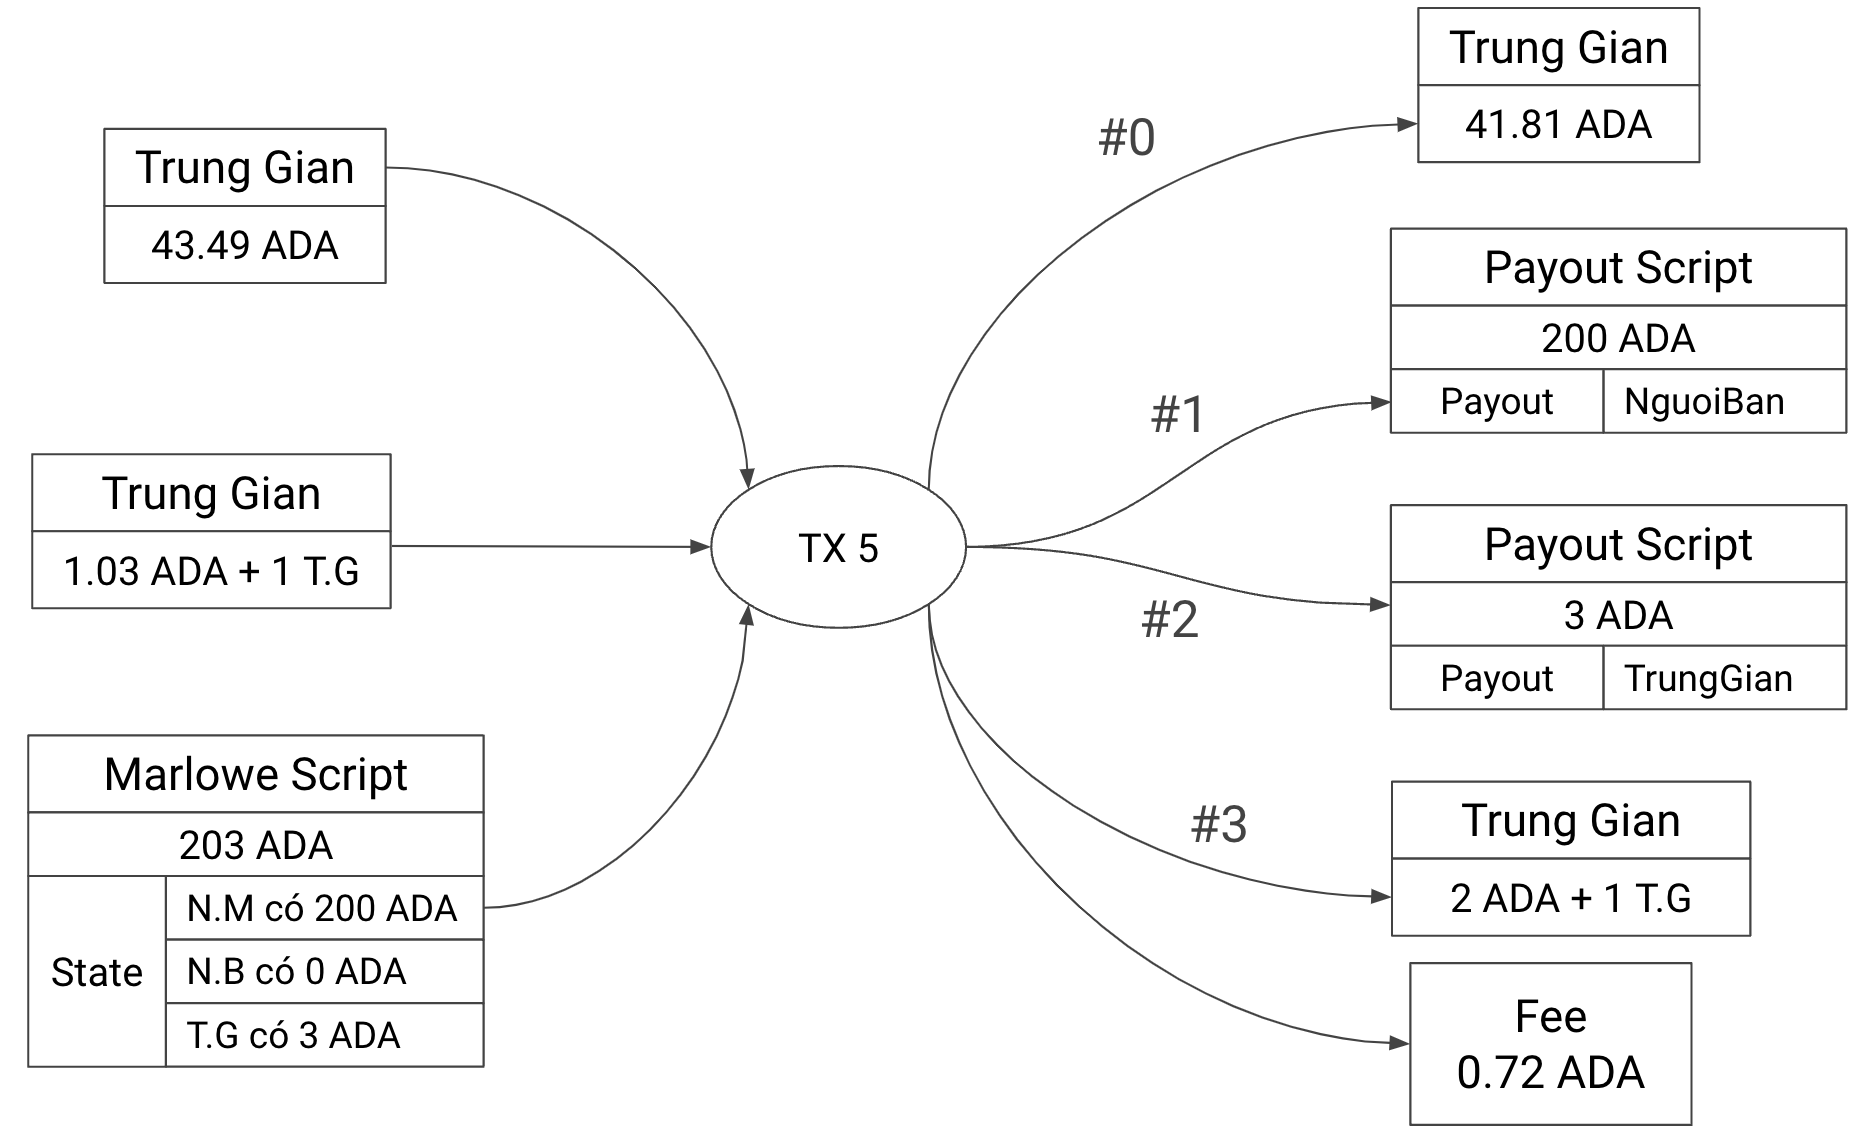

**Tạo ra file .marlowe chứa thông tin về trạng thái tiếp theo của hợp đồng**

In [ ]:
marlowe-cli --conway-era run prepare --marlowe-file tx-4.marlowe           \
                        --choice-name "Dismiss claim"                      \
                        --choice-party "$MEDIATOR_ROLE"                    \
                        --choice-number 0                                  \
                        --invalid-before "$NOW"                            \
                        --invalid-hereafter "$((NOW+9*HOUR))"              \
                        --out-file tx-5.marlowe                            \
                        --print-stats

**Thực hiện bước tiếp theo của hợp đồng**
_(Trạng thái hiện tại + Bước tiếp theo = Trạng thái tiếp theo)_

In [ ]:
marlowe-cli --conway-era run execute --marlowe-in-file tx-4.marlowe                        \
                        --tx-in-marlowe "$TX_4#1"                                          \
                        --tx-in-collateral "$TX_1#0"                                       \
                        --tx-in "$TX_1#0"                                                  \
                        --tx-in "$TX_0_MEDIATOR_TOKEN"                                     \
                        --required-signer "$MEDIATOR_SKEY"                                 \
                        --marlowe-out-file tx-5.marlowe                                    \
                        --tx-out "$MEDIATOR_ADDRESS+$MINIMUM_ADA+1 $MEDIATOR_TOKEN"        \
                        --change-address "$MEDIATOR_ADDRESS"                               \
                        --out-file tx-5.raw                                                \
                        --print-stats                                                      \
                        --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 1034899
Size: 12139 / 16384 = 74%
Execution units:
  Memory: 4501347 / 14000000 = 32%
  Steps: 850176147 / 10000000000 = 8%
TxId "128d755557e63956ad34b6a70c36a82fd8fc9222dee82e120311407b71ba8b62"
```

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_5=33e837dd2ba7c0bee25fcc354e48989abca79063dc75d6f44ebf154482eed49d

In [ ]:
cardano-cli query utxo --testnet-magic "$CARDANO_TESTNET_MAGIC" --tx-in "$TX_5#0" --tx-in "$TX_5#1" --tx-in "$TX_5#2" --tx-in "$TX_5#3"

#### Transaction 6: Người bán rút tiền khỏi hợp đồng

**Các UTxOs trong transaction 6**

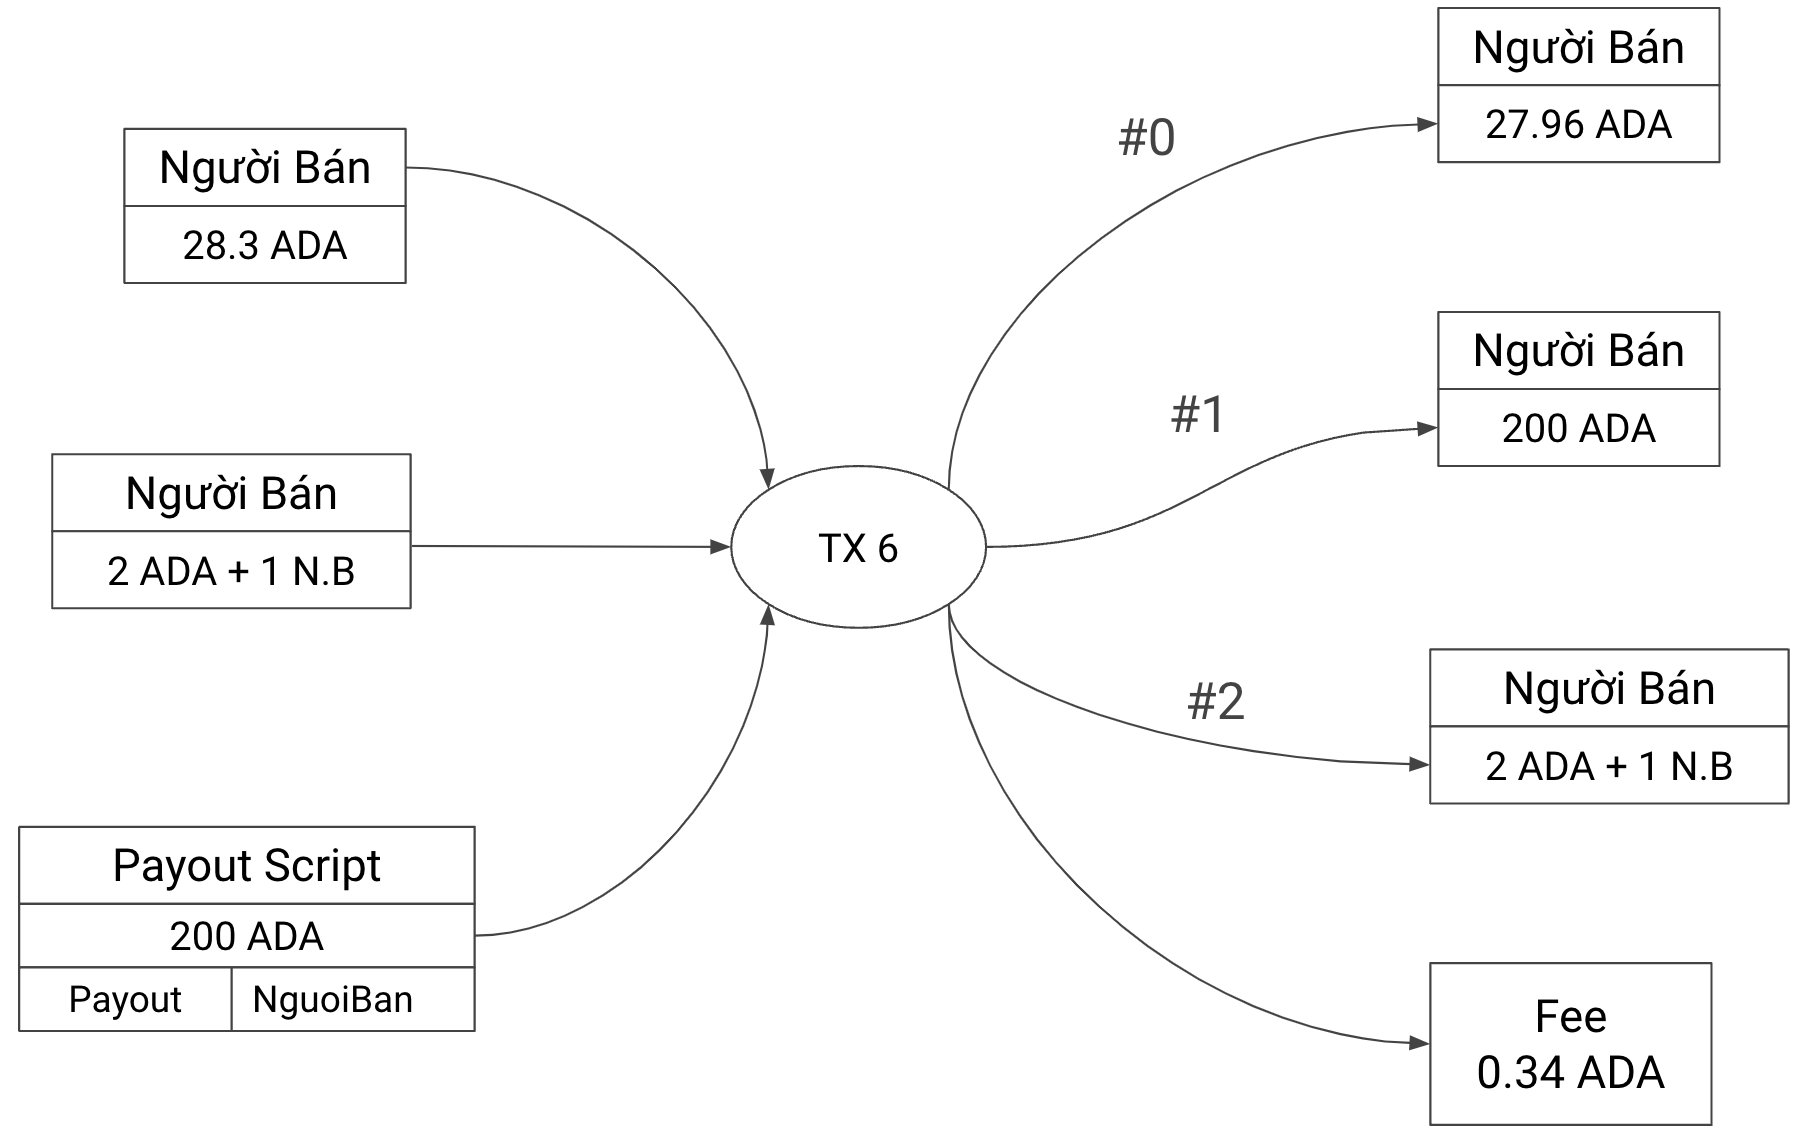

_Lệnh `marlowe-cli run withdraw` cho phép người bán rút tiền từ địa chỉ của Payout Script_

In [ ]:
marlowe-cli --conway-era run withdraw --marlowe-file tx-5.marlowe                     \
                           --role-name "$SELLER_ROLE"                                 \
                           --tx-in "$TX_4#0"                                          \
                           --tx-in "$TX_4#2"                                          \
                           --tx-in-collateral "$TX_4#0"                               \
                           --required-signer "$SELLER_SKEY"                           \
                           --tx-out "$SELLER_ADDRESS+$MINIMUM_ADA+1 $SELLER_TOKEN"    \
                           --change-address "$SELLER_ADDRESS"                         \
                           --out-file tx-6.raw                                        \
                           --print-stats                                              \
                           --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 409056
Size: 2978 / 16384 = 18%
Execution units:
  Memory: 1351416 / 14000000 = 9%
  Steps: 281414385 / 10000000000 = 2%
TxId "3279e4f8737cb604ca82f5bf57df73618359030635bccd5020af211585d74d82"
```

**Lưu lại id của transaction để dùng sau này**

In [ ]:
TX_6=103c27b9063ce56f1ec65fe2cacbac5485174ac53f8fc2b161f853d24adb9287

#### Transaction 7: Người trung gian rút tiền khỏi hợp đồng

**Các UTxOs trong transaction 7**

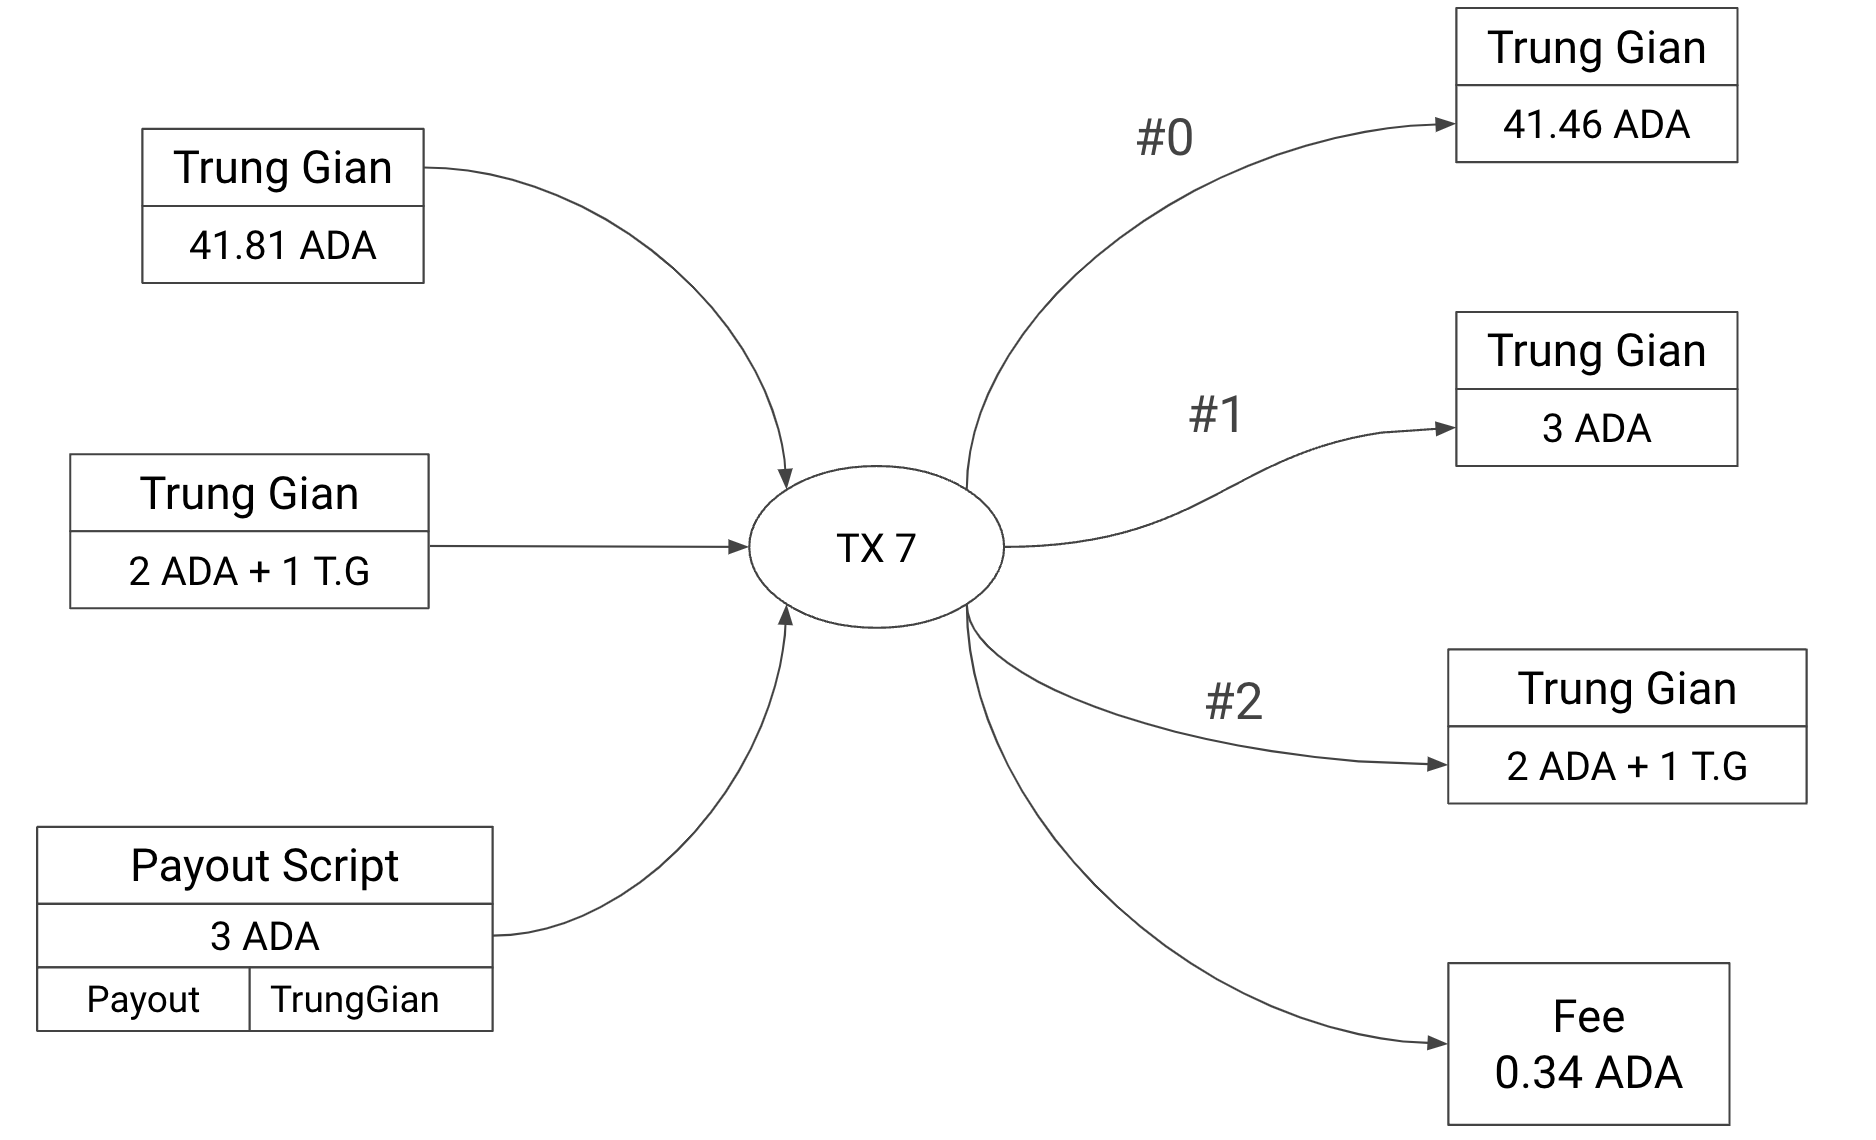

In [ ]:
marlowe-cli --conway-era run withdraw --marlowe-file tx-5.marlowe                    \
                         --role-name "$MEDIATOR_ROLE"                                \
                         --tx-in "$TX_5#0"                                           \
                         --tx-in "$TX_5#3"                                           \
                         --tx-in-collateral "$TX_5#0"                                \
                         --required-signer "$MEDIATOR_SKEY"                          \
                         --tx-out "$MEDIATOR_ADDRESS+$MINIMUM_ADA+1 $MEDIATOR_TOKEN" \
                         --change-address "$MEDIATOR_ADDRESS"                        \
                         --out-file tx-7.raw                                         \
                         --print-stats                                               \
                         --submit=600

_Kết quả thực hiện nếu không dùng reference script khi tạo hợp đồng_
```
Fee: Coin 409144
Size: 2980 / 16384 = 18%
Execution units:
  Memory: 1351416 / 14000000 = 9%
  Steps: 281414461 / 10000000000 = 2%
TxId "327a84c6fbc50588f14b6884d36fc88ec72f3e89130f8577e0789de4a3c20516"
```

In [ ]:
TX_7=56223cd8e0b912d530a1c6e549951b85d6808ecd25d425dc3568b79da76bedb0

#### Xem các transaction trên cardanoscan.io

In [ ]:
echo 'Transaction 1: https://preprod.cardanoscan.io/transaction/'"$TX_1"
echo 'Transaction 2: https://preprod.cardanoscan.io/transaction/'"$TX_2"
echo 'Transaction 3: https://preprod.cardanoscan.io/transaction/'"$TX_3"
echo 'Transaction 4: https://preprod.cardanoscan.io/transaction/'"$TX_4"
echo 'Transaction 5: https://preprod.cardanoscan.io/transaction/'"$TX_5"
echo 'Transaction 6: https://preprod.cardanoscan.io/transaction/'"$TX_6"
echo 'Transaction 7: https://preprod.cardanoscan.io/transaction/'"$TX_7"

Transaction 1: https://preprod.cardanoscan.io/transaction/33fe140376cf8c13a73af62afede6f8065322437325665953f9ae1737764fa57

Transaction 2: https://preprod.cardanoscan.io/transaction/2431839d46ce6d4a455d644f3dfce69cabcacb920497f24c3ac5781eb8ab5a8e

Transaction 3: https://preprod.cardanoscan.io/transaction/46c9e07fc4c80ae876fa111bcc7e3c0962c849965343178d6ddb18baecb17962

Transaction 4: https://preprod.cardanoscan.io/transaction/8a4f39b7ee52e8dfab946b649cceb2b398bfb0b6328310d14f10abd6d1dacdc9

Transaction 5: https://preprod.cardanoscan.io/transaction/33e837dd2ba7c0bee25fcc354e48989abca79063dc75d6f44ebf154482eed49d

Transaction 6: https://preprod.cardanoscan.io/transaction/103c27b9063ce56f1ec65fe2cacbac5485174ac53f8fc2b161f853d24adb9287

Transaction 7: https://preprod.cardanoscan.io/transaction/56223cd8e0b912d530a1c6e549951b85d6808ecd25d425dc3568b79da76bedb0